In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import numpy as np

# Download CIFAR 10 data form torchvision

In [2]:

train_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


# Image Contrasting

# Generate a list of contrast adjusted images

In [3]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

contrast_factor = 2 #0.3 # 0 gray - 1 original image - 2 increases the contrast by a factor of 2.

def apply_contrast(images, contrast_factor):
    to_tensor = transforms.ToTensor()   
    images_list = [to_tensor(im) for im in images]
    images = torch.stack(images_list)
    contrast_adjusted_images = F.adjust_contrast(images, contrast_factor)
    return contrast_adjusted_images 

train_contrasted_images = apply_contrast(train_dataset.data, contrast_factor)
test_contrasted_images = apply_contrast(test_dataset.data, contrast_factor)

train_contrasted_images = np.array(np.stack([transforms.ToPILImage()(im) for im in train_contrasted_images]))
test_contrasted_images = np.array(np.stack([transforms.ToPILImage()(im) for im in test_contrasted_images]))
print("Train contrast adjusted images shape")
print(train_contrasted_images.shape)

print("Test contrast adjusted images shape")
print(test_contrasted_images.shape)



Train contrast adjusted images shape
(50000, 32, 32, 3)
Test contrast adjusted images shape
(10000, 32, 32, 3)


# Visualizing generated contrast adjusted images

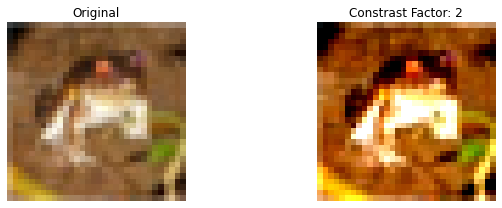

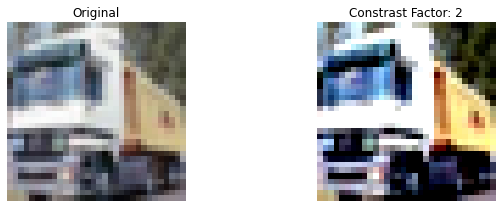

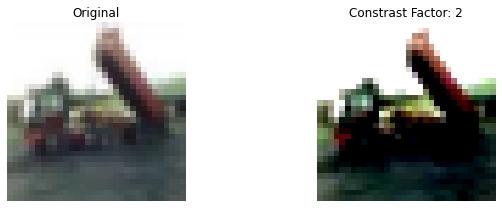

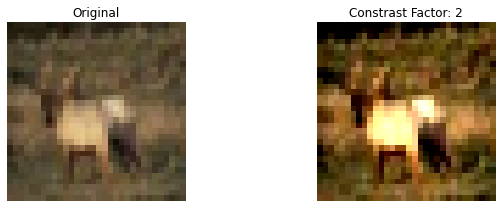

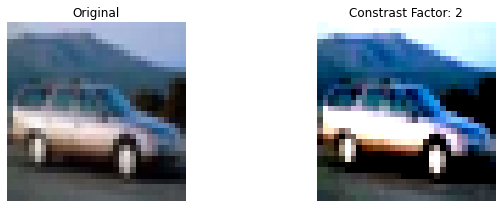

In [4]:
i=0
for constrasted_image in train_contrasted_images:
    fig = plt.figure(figsize=(10, 3))
    ax1,ax2 = fig.subplots(1,2)
    ax1.imshow(train_dataset.data[i], cmap='gray')
    ax1.set_axis_off()
    ax1.set_title("Original")
    ax2.imshow(constrasted_image, cmap='gray')
    ax2.set_axis_off()
    ax2.set_title("Constrast Factor: "+str(contrast_factor))
    fig.set_tight_layout(True)
    plt.show()
    i +=1
    
    if i==5:
        break
    

# Combining original and contrasted images

In [5]:
original_image_labels = np.zeros(len(train_dataset.data))
contrasted_image_labels = np.ones(len(train_contrasted_images))

test_original_image_labels = np.zeros(len(test_dataset.data))
test_contrasted_image_labels = np.ones(len(test_contrasted_images))

train_original_and_contrasted_images = np.concatenate((train_dataset.data, train_contrasted_images), axis=0)
train_contrast_labels = np.concatenate((original_image_labels, contrasted_image_labels), axis=None)
train_image_labels = np.concatenate((train_dataset.targets, train_dataset.targets), axis=None)

test_original_and_contrasted_images = np.concatenate((test_dataset.data, test_contrasted_images), axis=0)
test_contrast_labels = np.concatenate((test_original_image_labels, test_contrasted_image_labels), axis=None)


print("Combined contrasted and original train images shape")
print(train_original_and_contrasted_images.shape)


Combined contrasted and original train images shape
(100000, 32, 32, 3)


# Extract image features

In [6]:
from image_feature_extractor import Img2Vec

img2vec = Img2Vec(model="resnet50")
# img2vec = Img2Vec(model="vgg")
# img2vec = Img2Vec(model="resnet152")

Z = img2vec.get_vec(train_original_and_contrasted_images)

Z_test = img2vec.get_vec(test_original_and_contrasted_images)

Z_test_original = img2vec.get_vec(test_dataset.data)

Z_test_contrasted = img2vec.get_vec(test_contrasted_images)

# vec.shape
print("Shape of extracted features for combined contrasted and original images")
print(Z.shape)

print("Shape of extracted features for original test images")
print(Z_test_original.shape)

print("Shape of extracted features for contrasted test images")
print(Z_test_contrasted.shape)


Shape of extracted features for combined contrasted and original images
(100000, 2048)
Shape of extracted features for original test images
(10000, 2048)
Shape of extracted features for contrasted test images
(10000, 2048)


# Obtaining contrast prediction coefficients and contrast prediction accuracy

In [7]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression(random_state=0).fit(Z, train_contrast_labels)

contrast_coefficients = lr_model.coef_.reshape(-1,1)
contrast_coefficients = contrast_coefficients / np.linalg.norm(contrast_coefficients)

print("Contrast coefficients shape")
print(contrast_coefficients.shape)

print('Contrast prediction accuracy on training data-rotated and original combined: ', lr_model.score(Z, train_contrast_labels))
print('Contrast prediction accuracy on test data-rotated and original combined: ', lr_model.score(Z_test, test_contrast_labels))

    


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Contrast coefficients shape
(2048, 1)
Contrast prediction accuracy on training data-rotated and original combined:  0.95678
Contrast prediction accuracy on test data-rotated and original combined:  0.94885


# Prediction Accuracies on extracted image features Z ( features obtained from the feature extractor)

### Logistic Regression

In [8]:
# Trained on original extracted image features Z, tested on contrasted extracted image features Z
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


# targets_train = np.array(train_dataset.targets)
targets_train = train_image_labels[:len(train_image_labels)//2]
targets_test = np.array(test_dataset.targets)


logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(Z[:len(Z)//2,:], targets_train)

print('LR Accuracy on test data - Z original features: ',logistic_regression_model.score(Z_test_original, targets_test))
print('LR Accuracy on test data - Z contrasted features: ', logistic_regression_model.score(Z_test_contrasted, targets_test))



/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy on test data - Z original features:  0.7145
LR Accuracy on test data - Z contrasted features:  0.6241


### KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=223).fit(Z[:len(Z)//2,:], targets_train)

print('KNN Accuracy on test data - Z original features: ',knn_model.score(Z_test_original, targets_test))
print('KNN Accuracy on test data - Z contrasted features: ', knn_model.score(Z_test_contrasted, targets_test))


KNN Accuracy on test data - Z original features:  0.5849
KNN Accuracy on test data - Z contrasted features:  0.5276


# Find L, get F features, plot histograms and perform predictions

Results for lamda  0.001

Histogram for F Test feature  0


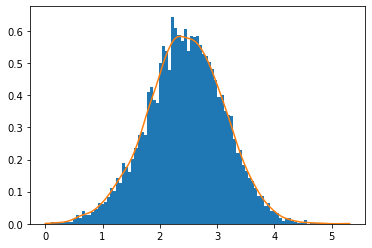

Histogram for F Test feature  1


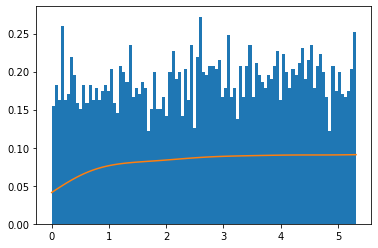

Histogram for F Test feature  2


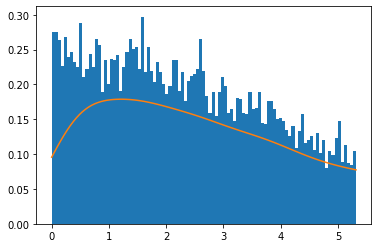

Histogram for F Test feature  3


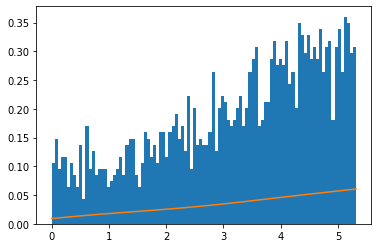

Histogram for F Test feature  4


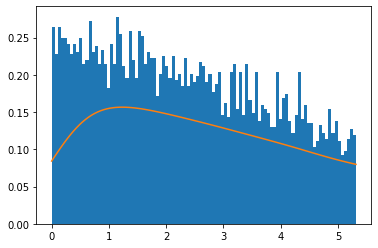

Histogram for F Test feature  5


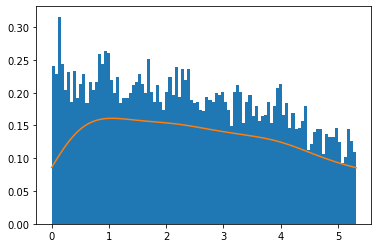

Histogram for F Test feature  6


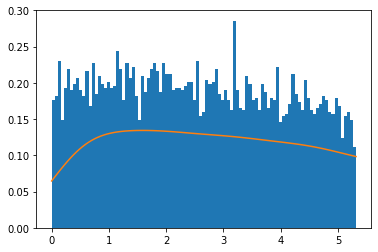

Histogram for F Test feature  7


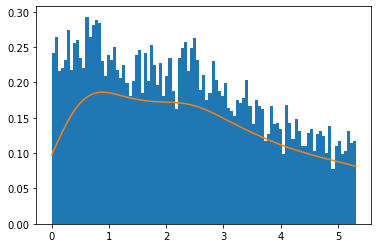

Histogram for F Test feature  8


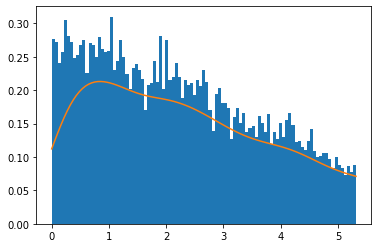

Histogram for F Test feature  9


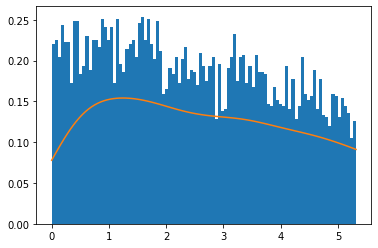

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy on test data - not contrasted - All F features:  0.6984
LR Accuracy on test data - contrasted - All F features:  0.6159


KNN Accuracy on test data - not contrasted - All F features:  0.5908
KNN Accuracy on test data - contrasted - All F features:  0.5306



Accuracy for without F feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6998
Logistic Regression Accuracy on test data - contrasted:  0.6174


KNN Accuracy on test data - not contrasted:  0.5912
KNN Accuracy on test data - contrasted:  0.5304


Accuracy for without F feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.697
Logistic Regression Accuracy on test data - contrasted:  0.6108


KNN Accuracy on test data - not contrasted:  0.5885
KNN Accuracy on test data - contrasted:  0.5421


Accuracy for without F feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6854
Logistic Regression Accuracy on test data - contrasted:  0.4724


KNN Accuracy on test data - not contrasted:  0.5866
KNN Accuracy on test data - contrasted:  0.5084


Accuracy for without F feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6991
Logistic Regression Accuracy on test data - contrasted:  0.613


KNN Accuracy on test data - not contrasted:  0.587
KNN Accuracy on test data - contrasted:  0.5414


Accuracy for without F feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6969
Logistic Regression Accuracy on test data - contrasted:  0.5852


KNN Accuracy on test data - not contrasted:  0.5869
KNN Accuracy on test data - contrasted:  0.5309









Results for lamda  0.01

Histogram for F Test feature  0


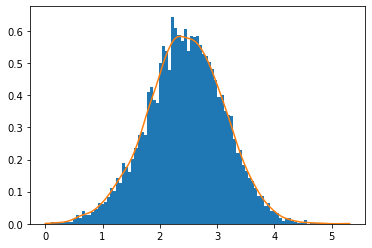

Histogram for F Test feature  1


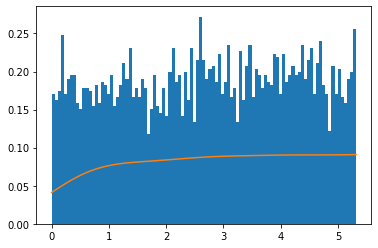

Histogram for F Test feature  2


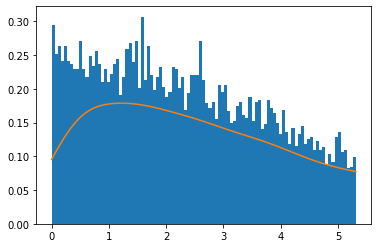

Histogram for F Test feature  3


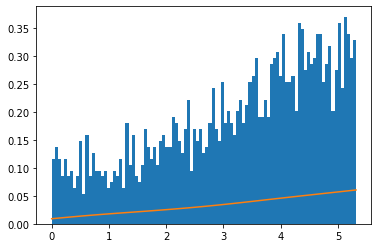

Histogram for F Test feature  4


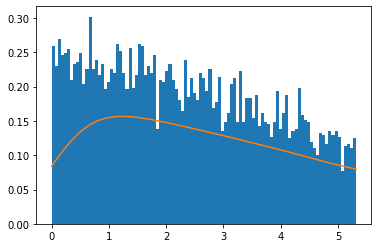

Histogram for F Test feature  5


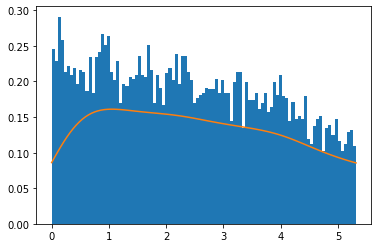

Histogram for F Test feature  6


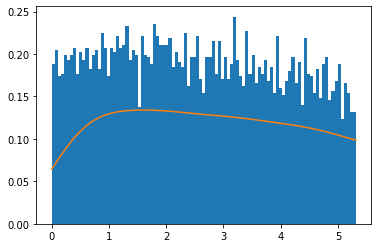

Histogram for F Test feature  7


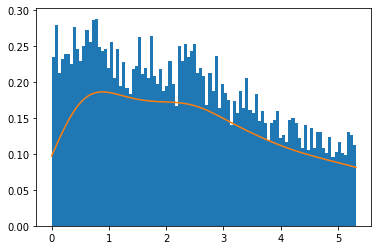

Histogram for F Test feature  8


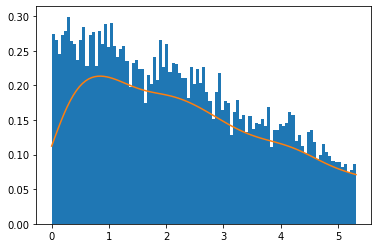

Histogram for F Test feature  9


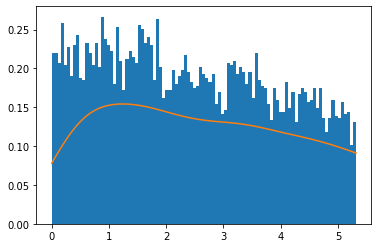

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy on test data - not contrasted - All F features:  0.698
LR Accuracy on test data - contrasted - All F features:  0.6165


KNN Accuracy on test data - not contrasted - All F features:  0.5912
KNN Accuracy on test data - contrasted - All F features:  0.5304



Accuracy for without F feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6995
Logistic Regression Accuracy on test data - contrasted:  0.6152


KNN Accuracy on test data - not contrasted:  0.5907
KNN Accuracy on test data - contrasted:  0.53


Accuracy for without F feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6973
Logistic Regression Accuracy on test data - contrasted:  0.6109


KNN Accuracy on test data - not contrasted:  0.5884
KNN Accuracy on test data - contrasted:  0.542


Accuracy for without F feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.687
Logistic Regression Accuracy on test data - contrasted:  0.4738


KNN Accuracy on test data - not contrasted:  0.5864
KNN Accuracy on test data - contrasted:  0.5084


Accuracy for without F feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6958
Logistic Regression Accuracy on test data - contrasted:  0.6109


KNN Accuracy on test data - not contrasted:  0.5872
KNN Accuracy on test data - contrasted:  0.541


Accuracy for without F feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6987
Logistic Regression Accuracy on test data - contrasted:  0.5856


KNN Accuracy on test data - not contrasted:  0.5867
KNN Accuracy on test data - contrasted:  0.5313









Results for lamda  10

Histogram for F Test feature  0


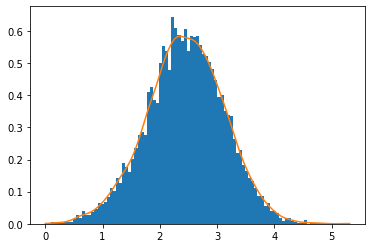

Histogram for F Test feature  1


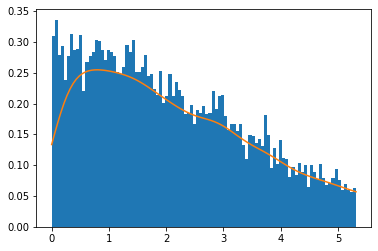

Histogram for F Test feature  2


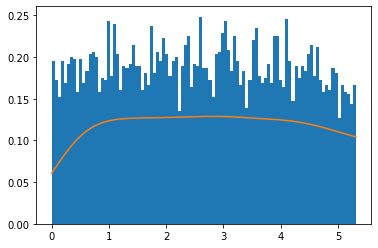

Histogram for F Test feature  3


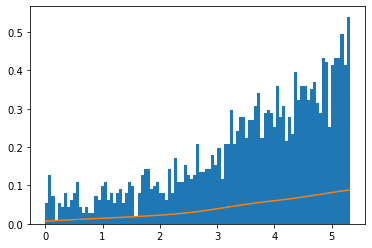

Histogram for F Test feature  4


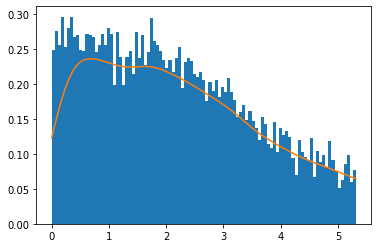

Histogram for F Test feature  5


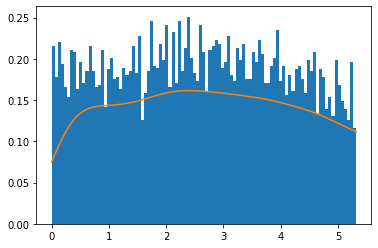

Histogram for F Test feature  6


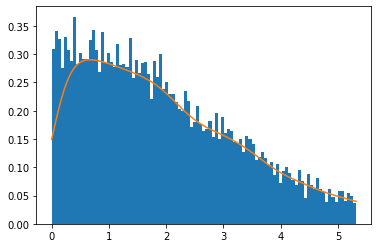

Histogram for F Test feature  7


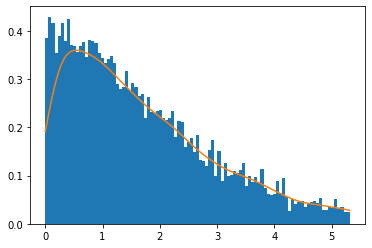

Histogram for F Test feature  8


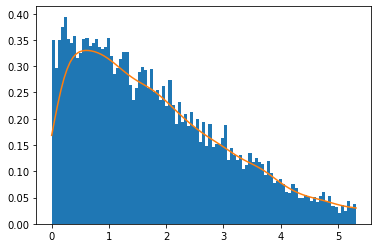

Histogram for F Test feature  9


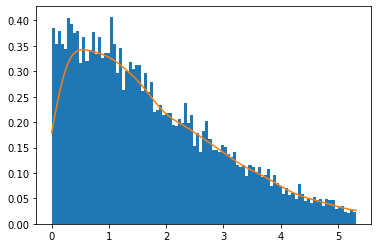

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy on test data - not contrasted - All F features:  0.672
LR Accuracy on test data - contrasted - All F features:  0.5973


KNN Accuracy on test data - not contrasted - All F features:  0.5945
KNN Accuracy on test data - contrasted - All F features:  0.5217



Accuracy for without F feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6718
Logistic Regression Accuracy on test data - contrasted:  0.5969


KNN Accuracy on test data - not contrasted:  0.5933
KNN Accuracy on test data - contrasted:  0.5224


Accuracy for without F feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6693
Logistic Regression Accuracy on test data - contrasted:  0.5931


KNN Accuracy on test data - not contrasted:  0.5942
KNN Accuracy on test data - contrasted:  0.523


Accuracy for without F feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6596
Logistic Regression Accuracy on test data - contrasted:  0.523


KNN Accuracy on test data - not contrasted:  0.5942
KNN Accuracy on test data - contrasted:  0.525


Accuracy for without F feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6688
Logistic Regression Accuracy on test data - contrasted:  0.5851


KNN Accuracy on test data - not contrasted:  0.5907
KNN Accuracy on test data - contrasted:  0.5226


Accuracy for without F feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6719
Logistic Regression Accuracy on test data - contrasted:  0.5799


KNN Accuracy on test data - not contrasted:  0.5908
KNN Accuracy on test data - contrasted:  0.5075









Results for lamda  100

Histogram for F Test feature  0


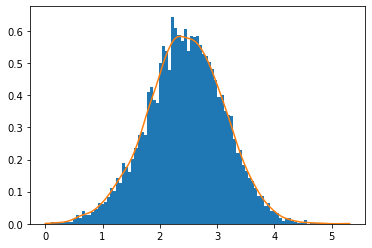

Histogram for F Test feature  1


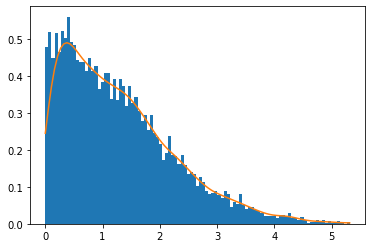

Histogram for F Test feature  2


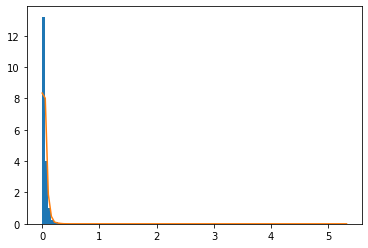

Histogram for F Test feature  3


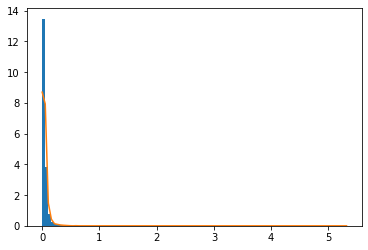

Histogram for F Test feature  4


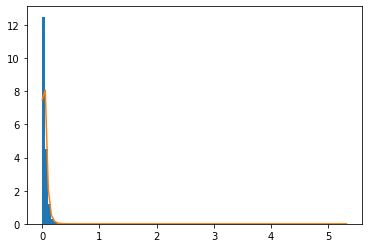

Histogram for F Test feature  5


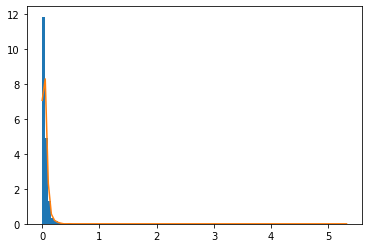

Histogram for F Test feature  6


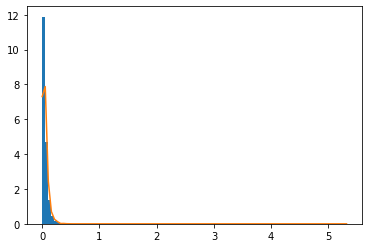

Histogram for F Test feature  7


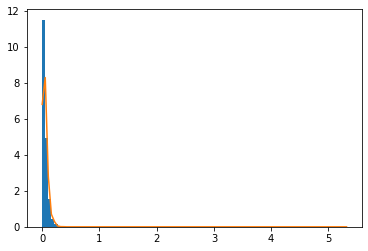

Histogram for F Test feature  8


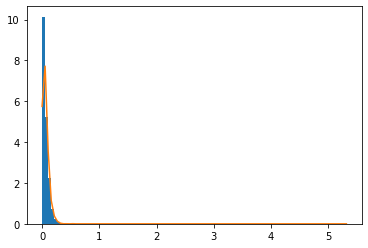

Histogram for F Test feature  9


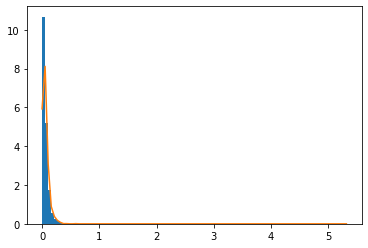

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy on test data - not contrasted - All F features:  0.6063
LR Accuracy on test data - contrasted - All F features:  0.5229


KNN Accuracy on test data - not contrasted - All F features:  0.4578
KNN Accuracy on test data - contrasted - All F features:  0.393



Accuracy for without F feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6077
Logistic Regression Accuracy on test data - contrasted:  0.5259


KNN Accuracy on test data - not contrasted:  0.4577
KNN Accuracy on test data - contrasted:  0.3905


Accuracy for without F feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6045
Logistic Regression Accuracy on test data - contrasted:  0.5269


KNN Accuracy on test data - not contrasted:  0.4663
KNN Accuracy on test data - contrasted:  0.4116


Accuracy for without F feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6073
Logistic Regression Accuracy on test data - contrasted:  0.5271


KNN Accuracy on test data - not contrasted:  0.4581
KNN Accuracy on test data - contrasted:  0.3927


Accuracy for without F feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.607
Logistic Regression Accuracy on test data - contrasted:  0.5249


KNN Accuracy on test data - not contrasted:  0.4578
KNN Accuracy on test data - contrasted:  0.3933


Accuracy for without F feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - not contrasted:  0.6067
Logistic Regression Accuracy on test data - contrasted:  0.5292


KNN Accuracy on test data - not contrasted:  0.4579
KNN Accuracy on test data - contrasted:  0.3933











In [10]:
import pandas as pd
from scipy import stats
# Computing M
lamdas = [0.001,0.01,10,100]

for lamda in lamdas:
    print("Results for lamda ", lamda)
    print()
    k = int(Z.shape[1]*0.2) # % of original number of features
    n = Z.shape[0]
    delta_Z_matrix = np.absolute((Z[:int(len(train_contrast_labels)/2),:] - Z[int(len(train_contrast_labels)/2):,:]))
    M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 


    # Computing the term on which we perform SVD
    alpha_alpha_T = contrast_coefficients @ contrast_coefficients.T
    d = alpha_alpha_T.shape[0]
    I = np.identity(d)
    I_minus_alpa_alpha_T = I-alpha_alpha_T
    term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T


    # Performing SVD to get eigenvectors and eigenvalues
    from numpy import linalg as LA
    eigenvalues, eigenvectors = LA.eigh(term_for_SVD)
#     print("Printing eigenvalues")
#     print(eigenvalues.shape)
#     print(eigenvalues)
#     print("Printing eigenvectors")
#     display(eigenvectors.shape)
#     display(eigenvectors)

    # Forming L from eigenvectors and alpha
    L_1 = contrast_coefficients
    least_k_eigen_values = eigenvalues[:k]
    least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

#     print("Printing least k eigenvalues before removing the zero eigenvalue")
#     print(least_k_eigen_values)

    non_zero_indeces = None
    if 0 in least_k_eigen_values:
        non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]
#         print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
#         print(least_k_eigen_values_without_0)

    else:
        non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]
#         print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
#         print(least_k_eigen_values_without_0)

#     print("Printing non zero indeces of the least k-1 eigenvalues") 
#     print(non_zero_indeces) #

    L_2 = eigenvectors[:,non_zero_indeces]

    # print(L_2.shape)

    L = np.concatenate((L_1, L_2), axis=1)

   
    # Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.
    F_train_original = torch.from_numpy(np.linalg.lstsq(L, Z[:len(Z)//2,:].transpose(), rcond=None)[0].transpose())
    F_test_original = torch.from_numpy(np.linalg.lstsq(L, Z_test_original.transpose(), rcond=None)[0].transpose())
    F_test_contrasted = torch.from_numpy(np.linalg.lstsq(L, Z_test_contrasted.transpose(), rcond=None)[0].transpose())



    # Plot histograms

    # the difference between F_test_green and F_test_red
    delta_matrix = np.absolute(F_test_original.detach().numpy() - F_test_contrasted.detach().numpy())

#     print("Printing the delta matrix")
    delta_matrix_df = pd.DataFrame(delta_matrix)
#     display(delta_matrix_df.head())

    # Plotting the histograms for each feature in the delta matrix # 100 bins
    for i in range(10): #(len(delta_matrix_df.columns)): 
        print("Histogram for F Test feature ", i)    
        feature = delta_matrix_df.iloc[:,i].values
        density = stats.gaussian_kde(feature)
        n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                           histtype='bar', density=True)  
        plt.plot(x, density(x))
        plt.show()
        
                
    
    
    
    # Trained on original images, tested on contrasted images: all Features in F_test
    from sklearn.linear_model import LogisticRegression

    import torch
    from sklearn import preprocessing
    from sklearn.neighbors import KNeighborsClassifier

    X_torch_train = F_train_original
    X_torch_test = F_test_contrasted
    X_torch_test_within = F_test_original
    
    targets_train = train_image_labels[:len(train_image_labels)//2]
    targets_test = np.array(test_dataset.targets)
    targets_test_within = np.array(test_dataset.targets)


    logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train.detach().numpy(), targets_train)

    print('LR Accuracy on test data - not contrasted - All F features: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_test_within))
    print('LR Accuracy on test data - contrasted - All F features: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_test))
    
    print("\n"*1)
    knn_model = KNeighborsClassifier(n_neighbors=223).fit(X_torch_train.detach().numpy(), targets_train)
    print('KNN Accuracy on test data - not contrasted - All F features: ',knn_model.score(X_torch_test_within, targets_test_within))
    print('KNN Accuracy on test data - contrasted - All F features: ', knn_model.score(X_torch_test, targets_test))
    print("\n"*2)
    

    # Trained on original images, tested on contrasted images: Contrast Features removed from F_test

    targets_train = train_image_labels[:len(train_image_labels)//2]
    targets_test = np.array(test_dataset.targets)
    targets_test_within = np.array(test_dataset.targets)

    for i in range(5): #(F_test_original.detach().numpy().shape[1]):
        print("Accuracy for without F feature ",i)

        X_torch_train = F_train_original.detach().numpy().copy()
        X_torch_test = F_test_contrasted.detach().numpy().copy()
        X_torch_test_within = F_test_original.detach().numpy().copy()

        X_torch_train = np.delete(X_torch_train, i, 1)
        X_torch_test = np.delete(X_torch_test, i, 1)
        X_torch_test_within = np.delete(X_torch_test_within, i, 1)


        logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train, targets_train)
        print('Logistic Regression Accuracy on test data - not contrasted: ',logistic_regression_model.score(X_torch_test_within, targets_test_within))
        print('Logistic Regression Accuracy on test data - contrasted: ', logistic_regression_model.score(X_torch_test, targets_test))
        print("\n"*1)
        knn_model = KNeighborsClassifier(n_neighbors=223).fit(X_torch_train, targets_train)
        print('KNN Accuracy on test data - not contrasted: ',knn_model.score(X_torch_test_within, targets_test_within))
        print('KNN Accuracy on test data - contrasted: ', knn_model.score(X_torch_test, targets_test))
        print("\n"*1)
    print("\n"*6)

